In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.15) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['NaiveModels.ipynb', '.ipynb_checkpoints', 'test.csv', 'train.csv', 'NaNHandleModels.ipynb', 'HousePrices.ipynb', 'OutlinersModels.ipynb', 'EDA.ipynb']


In [2]:
### 1. 'YearBuilt', "SaleCondition"
### 2. Random
### 3. All 

In [3]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [4]:
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test = pd.DataFrame.from_csv(test_path, index_col=0)
              
    return train, test

# Naive model

In [5]:
train, test = load_data()

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
train = train[['YearBuilt', "SaleCondition", "SalePrice"]]
test = test[['YearBuilt', "SaleCondition"]]

In [7]:
train.dropna(inplace=True, axis=0)
test.dropna(inplace=True, axis=0)

In [8]:
train.head()

,YearBuilt,SaleCondition,SalePrice
Id,,,
1,2003,Normal,208500
2,1976,Normal,181500
3,2001,Normal,223500
4,1915,Abnorml,140000
5,2000,Normal,250000


In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train.drop("SalePrice", axis=1), train.SalePrice, test_size=0.2, shuffle=None)

In [10]:
def regressor_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols):
    periods = 10
    steps_per_period = steps / periods
    # Create a linear classifier object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    regressor = tf.estimator.LinearRegressor(
        feature_columns=cols,
        optimizer=my_optimizer,
        model_dir='/tmp/model2'
    )
  
    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
    #     num_epochs=None,
        shuffle=True,
    #     target_column='target'
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )
  
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        training_predictions = regressor.predict(input_fn=ptraining_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = regressor.predict(input_fn=validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, y_train))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, y_test))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return regressor, training_rmse, validation_rmse

In [11]:
# yearb = tf.feature_column.numeric_column('YearBuilt')
cols = []
# cond = tf.feature_column.categorical_column_with_vocabulary_list('SaleCondition', ['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'])


cols = [tf.feature_column.numeric_column(i) for i in train.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).columns.values]
# cols = [yearb]
# cols = [cond]

W0304 19:26:38.296941 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0304 19:26:38.315133 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0304 19:26:38.319410 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow_estimator/python/estimator/input


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
LogLoss (on training data):


W0304 19:26:38.511892 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
W0304 19:26:38.855933 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/monitored_session.py:827: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0304 19:26:39.409726 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instruction

  period 00 : 197433.50


W0304 19:26:40.029406 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1069: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


  period 01 : 197388.36
  period 02 : 197343.22
  period 03 : 197298.09


W0304 19:26:44.506666 140488832464640 deprecation.py:323] From /home/lazukav/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py:965: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


  period 04 : 197252.95
  period 05 : 197207.82
  period 06 : 197162.69
  period 07 : 197117.56
  period 08 : 197072.43
  period 09 : 197027.31
Model training finished.
Final RMSE (on training data):   197027.31
Final RMSE (on validation data): 197544.35


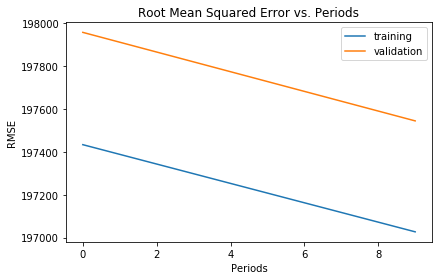

In [12]:
regressor = regressor_model(
    learning_rate=0.0005,
    steps=500,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols)